In [1]:
from get_data import get_train_test_data
from datetime import datetime
import pandas as pd
from get_heston_parameters import infer_heston_parameters
from neural_heston import Heston
import matplotlib.pyplot as plt
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from train import loss
import torch
plt.style.use('dark_background')

In [2]:
STOCK_NAME = "MSFT"
START = datetime(2015, 1, 1)
TEST_START = datetime(2023, 1, 1)
END = datetime(2024, 1, 1)
PREDICITON_PERIOD = 60
NUM_SIMULATIONS = 16
DT = 1
EPOCHS = 100

In [3]:
train_data, test_data = get_train_test_data(STOCK_NAME, START, TEST_START, PREDICITON_PERIOD)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
# weight initialisation
all_parameters = []
for trajectory in train_data:
    parameters = infer_heston_parameters(trajectory)
    all_parameters.append(parameters)
all_parameters = pd.DataFrame(all_parameters)
initial_parameters = dict(all_parameters.mean())

In [5]:
neural_heston = Heston(**initial_parameters)

In [6]:
def plot(actual_predict):
    fig, axs = plt.subplots(len(test_data), 1)
    fig.set_size_inches(5, 36)
    fig.suptitle(STOCK_NAME)

    for i, (actual, predictions) in enumerate(actual_predict):
        for j, prediction in enumerate(predictions[..., 0].transpose(0, 1)):
            axs[i].plot(actual.index, prediction.detach(), c="red", alpha=.5, label="simulation ($S$)" if j == 0 else None)
        axs[i].plot(actual.index, list(actual["S"]), c="purple", linewidth=3, label="market data ($S$)")
        axs[i].set_title(f"{actual.index[0].date()} until {actual.index[-1].date()}")
        axs[i].legend()
        axs[i].set_xticks([])

    plt.show()

In [7]:
list(neural_heston.parameters())

[Parameter containing:
 tensor(-0.0001, dtype=torch.float64),
 Parameter containing:
 tensor(0.),
 Parameter containing:
 tensor(2.6246, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.0003, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.0131, dtype=torch.float64, requires_grad=True),
 Parameter containing:
 tensor(0.)]

EPOCH 0: 647.539682419284


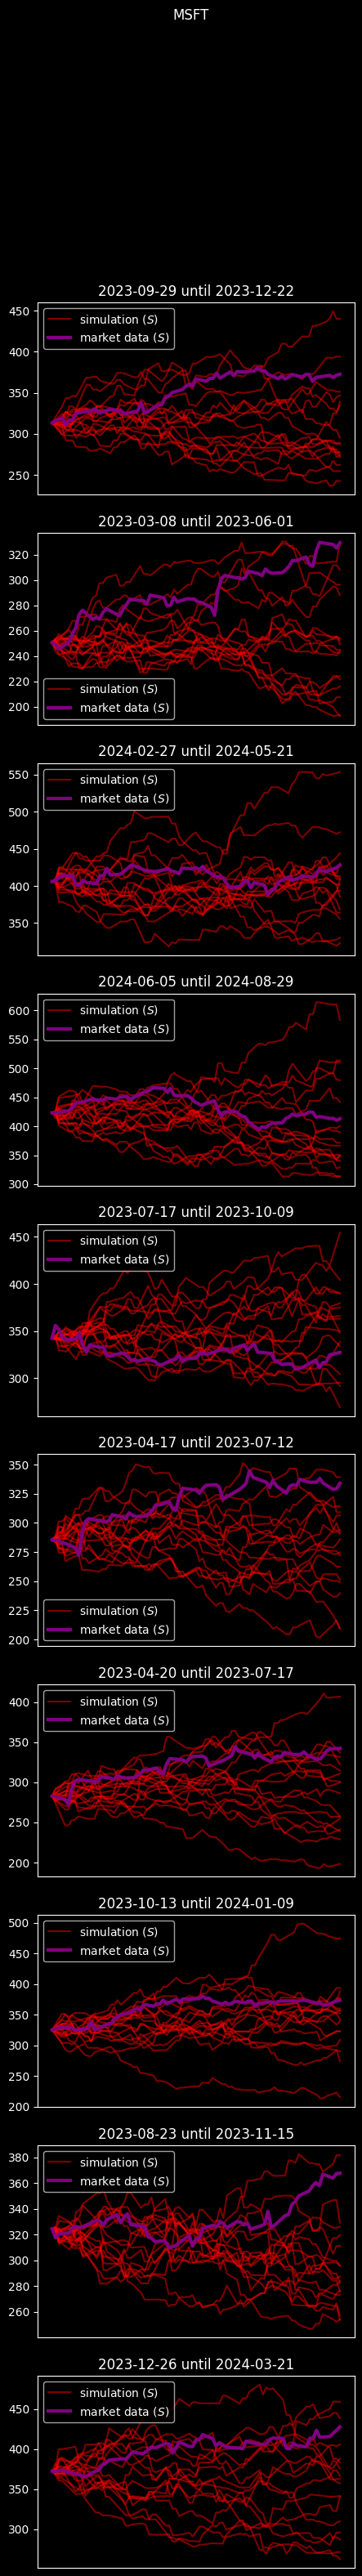

EPOCH 1: 458.23955547150103
EPOCH 2: 462.88579864643197
EPOCH 3: 460.25556858804396
EPOCH 4: 457.5441707080229
EPOCH 5: 455.71542765774296
EPOCH 6: 458.9004881430144
EPOCH 7: 462.4636016679529
EPOCH 8: 453.0325074453276
EPOCH 9: 459.82122436290285
EPOCH 10: 461.66708612457137
EPOCH 11: 467.30772625122034
EPOCH 12: 459.85387593410417
EPOCH 13: 457.2334614182035
EPOCH 14: 462.3965706385699
EPOCH 15: 459.74615987807954
EPOCH 16: 457.7842093613535
EPOCH 17: 457.4267937000278
EPOCH 18: 461.42434022832543
EPOCH 19: 457.2082310056636
EPOCH 20: 459.45682052600654
EPOCH 21: 460.1237838568849
EPOCH 22: 459.0303696805094
EPOCH 23: 462.27783443909914
EPOCH 24: 463.50296972506453
EPOCH 25: 462.03534619268135
EPOCH 26: 454.6045362354251
EPOCH 27: 461.29408574486763
EPOCH 28: 459.85805272610844
EPOCH 29: 459.2275499503739
EPOCH 30: 462.86267113308
EPOCH 31: 462.17813972208546
EPOCH 32: 462.6287418945261
EPOCH 33: 458.8175323150132
EPOCH 34: 462.6899119042512
EPOCH 35: 452.8890191869504
EPOCH 36: 458.

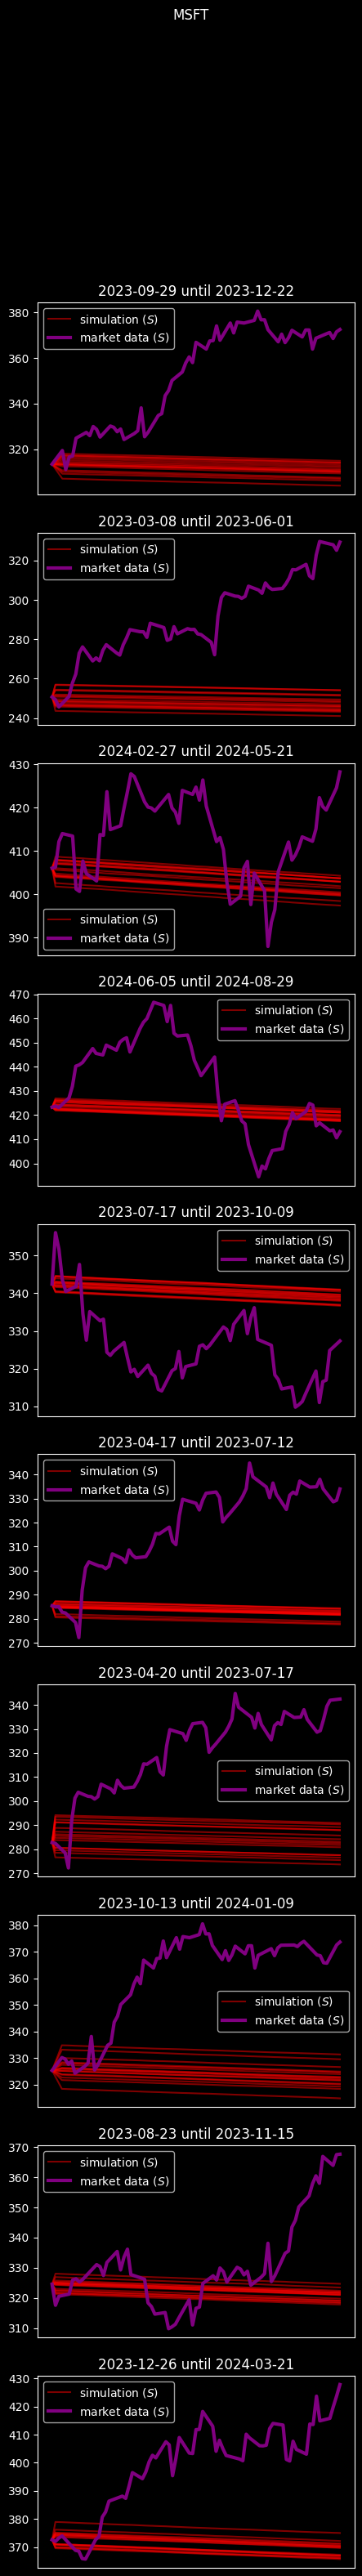

EPOCH 51: 463.6103136797441
EPOCH 52: 467.0009583597395
EPOCH 53: 461.5961882347103
EPOCH 54: 458.8793700284845
EPOCH 55: 459.4380664533254
EPOCH 56: 460.9556151009432
EPOCH 57: 457.9086631243857
EPOCH 58: 461.76399601812756
EPOCH 59: 457.7465254653726
EPOCH 60: 464.5860911051133
EPOCH 61: 454.26708145151133
EPOCH 62: 460.5908008742377
EPOCH 63: 459.95486548778877
EPOCH 64: 457.48354652471335
EPOCH 65: 461.5086832398388
EPOCH 66: 462.19757557691105
EPOCH 67: 460.230793637987
EPOCH 68: 457.2404167623919
EPOCH 69: 461.8258507210062
EPOCH 70: 459.75642480349023
EPOCH 71: 460.29460862363305
EPOCH 72: 453.3521004681935
EPOCH 73: 454.2163770042411
EPOCH 74: 458.43332470754007
EPOCH 75: 467.081553015231
EPOCH 76: 456.01901096974643
EPOCH 77: 455.3051778248529
EPOCH 78: 459.1650819853142
EPOCH 79: 459.78380924776246
EPOCH 80: 454.6312303469581
EPOCH 81: 460.6735310405226
EPOCH 82: 459.18970700374496
EPOCH 83: 461.632981949334
EPOCH 84: 457.0162738076787
EPOCH 85: 461.6904437418642
EPOCH 86: 45

In [8]:
optimizer = torch.optim.Adam(neural_heston.parameters())

for epoch in range(EPOCHS):
    
    print(f"EPOCH {epoch}:", end=" ")
    neural_heston.train()
    optimizer.zero_grad()
    actual_predict = []

    for actual in test_data:
        predictions = neural_heston.predict(actual, num_simulations=NUM_SIMULATIONS, dt=DT)
        actual_predict.append((actual, predictions))
    
    error = loss(actual_predict)
    print(error.item())

    if not epoch % 50:
        plot(actual_predict)
    
    error.backward()
    optimizer.step()
